# Train model

In [177]:
from ai_api_client_sdk.ai_api_v2_client import AIAPIV2Client
import json

In [178]:
# Your service key JSON file relative to this notebook
aic_service_key_path = '../files/aic_service_key.json'

# Loads the service key file
with open(aic_service_key_path) as ask:
    aic_service_key = json.load(ask)

# Creating an AI API client instance
ai_api_client = AIAPIV2Client(
    base_url = aic_service_key["serviceurls"]["AI_API_URL"] + "/v2", # The present AI API version is 2
    auth_url=  aic_service_key["url"] + "/oauth/token",
    client_id = aic_service_key['clientid'],
    client_secret = aic_service_key['clientsecret']
)

# Connect Docker to SAP AI Core

### Already done in defect detection exercise

# Create and upload the docker images

Start docker on your machine and execute the following commands in a terminal:

docker login docker.io -u YOUR_DOCKER_REPO

docker build code/train -t YOUR_DOCKER_REPO/sound-train:0.0.1 

docker push docker.io/YOUR_DOCKER_REPO/sound-train:0.0.1

NB: you should be connected to SAP VPN to download sap-ai-tracking module

# Create Resource Group and Connect AWS S3 to SAP AI Core

In [31]:
# Loads your service key
s3_service_key_path = '../files/s3_service_key.json'

# Loads the service key file
with open(s3_service_key_path) as s3sk:
    s3_service_key = json.load(s3sk)

default_secret = {
    "name": "default", # Name of the connection
    "type": "S3",
    "endpoint": s3_service_key["host"],
    "bucket": s3_service_key["bucket"],
    "pathPrefix": "sound",
    "region": s3_service_key["region"],
    "data": {
        "AWS_ACCESS_KEY_ID": s3_service_key["access_key_id"],
        "AWS_SECRET_ACCESS_KEY": s3_service_key["secret_access_key"]
    }
}

# Call the api
ai_api_client.rest_client.post(
    path="/admin/objectStoreSecrets",
    body = default_secret, # defined above
    resource_group = "sound"
)

{'message': 'Secret exists'}

In [32]:
ai_api_client.rest_client.get(
    path="/admin/objectStoreSecrets",
    resource_group = "sound"
)

{'count': 2,
 'resources': [{'metadata': {'serving.kubeflow.org/s3-endpoint': 's3.amazonaws.com',
    'serving.kubeflow.org/s3-region': 'eu-central-1',
    'serving.kubeflow.org/s3-usehttps': '',
    'serving.kubeflow.org/s3-verifyssl': '',
    'storage.ai.sap.com/bucket': 'books-dataset',
    'storage.ai.sap.com/endpoint': 's3.amazonaws.com',
    'storage.ai.sap.com/path_prefix': 'sound',
    'storage.ai.sap.com/region': 'eu-central-1',
    'storage.ai.sap.com/type': 'S3'},
   'name': 'default'},
  {'metadata': {'serving.kubeflow.org/s3-endpoint': 's3.amazonaws.com',
    'serving.kubeflow.org/s3-region': 'eu-central-1',
    'serving.kubeflow.org/s3-usehttps': '',
    'serving.kubeflow.org/s3-verifyssl': '',
    'storage.ai.sap.com/bucket': 'books-dataset',
    'storage.ai.sap.com/endpoint': 's3.amazonaws.com',
    'storage.ai.sap.com/path_prefix': 'sound',
    'storage.ai.sap.com/region': 'eu-central-1',
    'storage.ai.sap.com/type': 'S3'},
   'name': 'sound-data'}]}

In [181]:
app_name = "aicore-sound"

ai_api_client.rest_client.get(
    path=f"/admin/applications/{app_name}/status"
)

{'health_status': 'Healthy',
 'message': 'one or more objects failed to apply (retried 5 times).',
 'reconciled_at': '2022-03-03T17:35:45Z',
 'source': {'path': 'workflows_sound',
  'repourl': 'https://github.com/calabria/aicore-test',
  'revision': '5afbeae0d92ab8a2bcdf4d9d163da55c4cf309cd'},
 'sync_finished_at': '2022-03-03T17:02:09Z',
 'sync_ressources_status': [{'kind': 'ServingTemplate',
   'message': 'admission webhook "servingtemplatevalidator.ai.sap.com" denied the request: v1alpha1.ai.sap.com "sound-serve" is invalid: [spec.inputs.artifacts[0]: Invalid value: "sound-model": [sound-model] is not in correct format. Accepted format is [^[a-zA-Z0-9\\_]+$], spec.template: Invalid value: "predictor:\\n  imagePullSecrets:\\n    - name: docker-registry-secret\\n  minReplicas: 1\\n  maxReplicas: 5\\n  containers:\\n  - name: kfserving-container\\n    image: \\"docker.io/yoshidj/sound-serve:0.0.1\\"\\n    ports:\\n      - containerPort: 9001\\n        protocol: TCP\\n    env:\\n      - 

# Train Execution of ML Model

In [134]:
import sys, os
import json
import requests
import base64
import time
import yaml
from IPython.display import clear_output
from pprint import pprint

from ai_api_client_sdk.ai_api_v2_client import AIAPIV2Client
from ai_api_client_sdk.models.artifact import Artifact
from ai_api_client_sdk.models.status import Status
from ai_api_client_sdk.models.target_status import TargetStatus
from ai_api_client_sdk.models.parameter_binding import ParameterBinding
from ai_api_client_sdk.models.input_artifact_binding import InputArtifactBinding

In [5]:
resource_group = "sound"  # Must be created before

aic_service_key = '../files/aic_service_key.json' # ENSURE YOU HAVE THE FILE PLACED CORRECTLY
with open(aic_service_key) as ask:
    aic_s_k = json.load(ask)

# NO CHANGES REQUIRED BELOW
#
ai_api_v2_client = AIAPIV2Client(
    base_url=aic_s_k["serviceurls"]["AI_API_URL"] + "/v2/lm",
    auth_url=aic_s_k["url"] + "/oauth/token",
    client_id=aic_s_k['clientid'],
    client_secret=aic_s_k['clientsecret'],
    resource_group=resource_group)

Check the available scenarios

In [6]:
scenario_resp = ai_api_v2_client.scenario.query(resource_group)

print("Scenarios")
print("---" * 20)
for idx, scenario in enumerate(scenario_resp.resources):
    print(f"Scenario ID {idx + 1} -> [{scenario.id}]")

Scenarios
------------------------------------------------------------
Scenario ID 1 -> [text-clf-tutorial]
Scenario ID 2 -> [image-clf-tutorial]
Scenario ID 3 -> [sound-scenario]


Register training data as artifact

In [10]:
# NO CHANGES REQUIRED BELOW
#
# Load training_workflow.yaml
training_workflow_file = '../workflows_sound/training_workflow.yaml'
with open(training_workflow_file) as twf:
    training_workflow = yaml.safe_load(twf)
#
# Load scenario id from train_workflow.yaml
scenario_id = training_workflow['metadata']['labels']['scenarios.ai.sap.com/id']
#
# Set the artifact configuration
artifact = {
        "name": "sound-data", # Modifiable Name
        "kind": Artifact.Kind.DATASET,
        "url": "ai://default/data",
        "description": "Cutting machine sound clips for defect detection",
        "scenario_id": scenario_id
    }
# Store the artifact response to retrieve the id for the training configuration
artifact_resp = ai_api_v2_client.artifact.create(**artifact)
print(f"Artifacts registered for {scenario_id} scenario!")
pprint(vars(artifact_resp))
#
# Checks if the message contains expected string
assert artifact_resp.message == 'Artifact acknowledged'

Artifacts registered for sound-scenario scenario!
{'id': 'f040d342-dad7-49d3-a416-b49168d6b883',
 'message': 'Artifact acknowledged',
 'url': 'ai://default/data'}


Create training configuration

In [43]:
input_artifact_name = training_workflow['spec']['templates'][0]['inputs']['artifacts'][0]['name']
executable_name = training_workflow['metadata']['name']

artifact_binding = {
    "key": input_artifact_name,
    "artifact_id": artifact_resp.id
}

train_configuration = {
    "name": "sound-training-configuration",
    "scenario_id": scenario_id,
    "executable_id": executable_name,
    "parameter_bindings": [],
    "input_artifact_bindings": [ InputArtifactBinding(**artifact_binding) ]
}

# store the configuration response to access the id to create an execution
train_config_resp = ai_api_v2_client.configuration.create(**train_configuration)
pprint(vars(train_config_resp))

assert train_config_resp.message == 'Configuration created'

print("Configuration created for running the training")

{'id': '679c3c7f-d765-42ce-9868-26856d29443a',
 'message': 'Configuration created'}
Configuration created for running the training


Create training execution

In [44]:
execution_resp = ai_api_v2_client.execution.create(train_config_resp.id)
pprint(vars(execution_resp))

{'id': 'e00b556ba011be5f',
 'message': 'Execution scheduled',
 'status': <Status.UNKNOWN: 'UNKNOWN'>}


Observe training status

In [45]:
status = None
while status != Status.COMPLETED and status != Status.DEAD:
    # Sleep for 5 secs to avoid overwhelming the API with requests
    time.sleep(5)
    # Clear outputs to reduce clutter
    clear_output(wait=True)

    execution = ai_api_v2_client.execution.get(execution_resp.id)
    status = execution.status
    print('...... execution status ......', flush=True)
    print(f"Training status: {execution.status}")
    print(f"Training status details: {execution.status_details}")


if execution.status == Status.COMPLETED:
    print(f"Training complete for execution [{execution_resp.id}]!")
    output_artifact = execution.output_artifacts[0]
    output = {
        "id": output_artifact.id,
        "name": output_artifact.name,
        "url": output_artifact.url
    }
    with open('training_output.json', 'w') as fp:
        json.dump(output, fp)

...... execution status ......
Training status: Status.COMPLETED
Training status details: {'details': [{'container_name': 'main', 'exit_code': 0, 'last_log_messages': '2 INFO - *** - MLTrackingSDK initialized2022-03-02 21:57:58,042:***:INFO - MLTrackingSDK initialized/app/model:total 17004-rw-r--r--. 1 nobody nogroup 17408387 Mar  2 21:57 ***---End Training---...', 'message': '', 'pod_name': 'e00b556ba011be5f', 'ready': False}, {'container_name': 'wait', 'exit_code': '', 'last_log_messages': 'it a7d560151d74adc3e0fa897f05347e63ce75e58b98a6ea622589502b33eaada7 174309482f661b107ace531bc941e8f693294ec0bfee083e918e2d4046c9955f 61961cc0ecaac0e8539d0d823c6d500066511fc2a00bc1f3573423fe3ddd96c4]"...', 'message': '', 'pod_name': 'e00b556ba011be5f', 'ready': True}], 'workflow_info': [{'exit_code': '', 'id': 'e00b556ba011be5f', 'message': '', 'name': 'e00b556ba011be5f', 'outputs': '', 'phase': 'Running', 'type': 'Pod'}]}
Training complete for execution [e00b556ba011be5f]!


# Metrics and performance

In [46]:
filter_string = "executionId eq '" + execution_resp.id + "'"
metric_resp = ai_api_v2_client.metrics.query(execution_ids=execution_resp.id)

for m in metric_resp.resources:
    for metric in m.metrics:
        print(metric.name)
        print(metric.value)

Model Accuracy
1.0


In [47]:
all_metrics = []
for m in metric_resp.resources:
    for custom_info in m.custom_info:
        #print(custom_info.name)
        #print(custom_info.value)
        all_metrics.append(custom_info.value)

In [48]:
import ast
import re
import numpy as np

training_metrics = ast.literal_eval(all_metrics[0])
confusion_matrix = ast.literal_eval(all_metrics[1])
#print(training_metrics[0].get("loss"))
#print(confusion_matrix[0].get("actual label - 0"))
#print(confusion_matrix[1].get("actual label - 1"))

a = confusion_matrix[0].get("actual label - 0")
b = confusion_matrix[1].get("actual label - 1")

a = [int(x) for x in re.split('[^0-9]', a) if x]
b = [int(x) for x in re.split('[^0-9]', b) if x]
#print(a)
#print(b)

cnf_matrix = np.array([a, b])
print(cnf_matrix)

[[23  0]
 [ 0 17]]


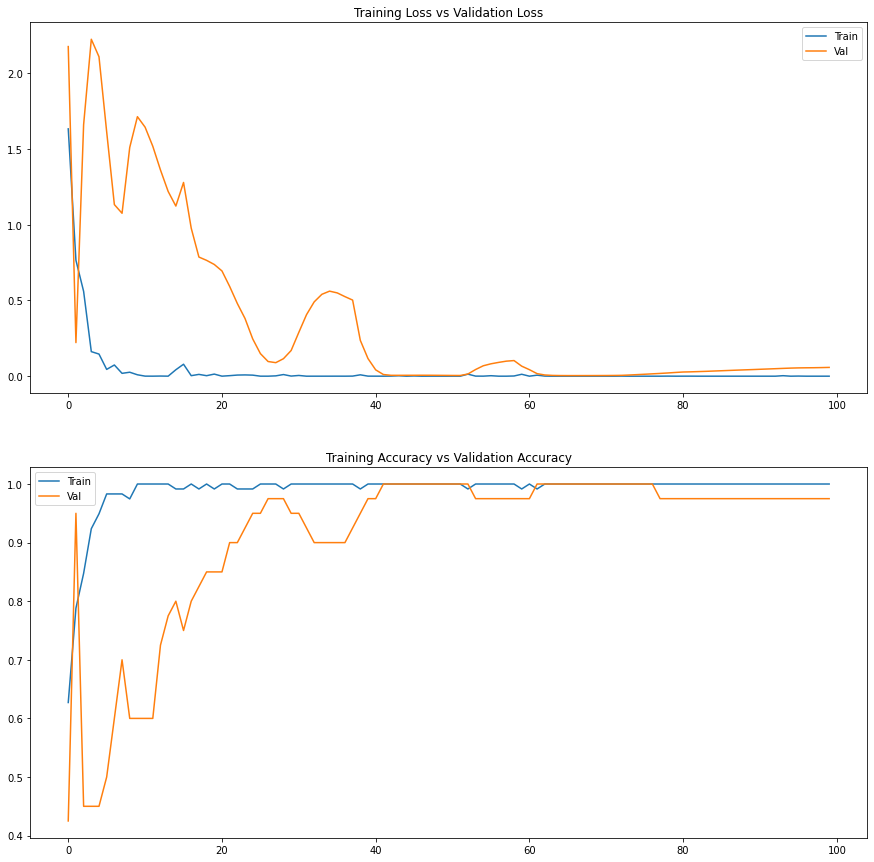

In [49]:
import matplotlib
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1, figsize=(15,15))

a = ast.literal_eval(training_metrics[0].get("loss"))
b = ast.literal_eval(training_metrics[1].get("val_loss"))
c = ast.literal_eval(training_metrics[2].get("accuracy"))
d = ast.literal_eval(training_metrics[3].get("val_accuracy"))

axs[0].plot(a)
axs[0].plot(b)
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].legend(['Train', 'Val'])

axs[1].plot(c)
axs[1].plot(d)
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].legend(['Train', 'Val'])

In [50]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


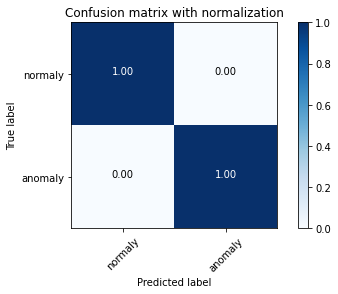

In [51]:
import itertools

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["normaly","anomaly"], normalize=True,
                      title='Confusion matrix with normalization')

# Deploy ML Model

First prepare the docker image with the proper content (check the Dockerfile content). 
Then build and upload with the following commands. 
The docker image will contain your infer.py code that specifies the behavior of the API you will deploy.

- docker build -t yoshidj/sound-serve:0.0.1 .

- docker push docker.io/yoshidj/sound-serve:0.0.1

In [182]:
serving_workflow_file = '../workflows_sound/serving_workflow_tutorial.yaml'
with open(serving_workflow_file) as swf:
    serving_workflow = yaml.safe_load(swf)

scenario_id = serving_workflow['metadata']['labels']['scenarios.ai.sap.com/id']
input_artifact_name = serving_workflow['spec']['inputs']['artifacts'][0]['name']
executable_name = serving_workflow['metadata']['name']

training_output = 'training_output.json'
with open(training_output) as to:
    serving_input = json.load(to)

In [183]:
artifact_binding = {
    "key": input_artifact_name,
    "artifact_id": serving_input["id"]
}

serve_configuration = {
    "name": "dev-tutorial-serving-configuration",
    "scenario_id": scenario_id,
    "executable_id": executable_name,
    "parameter_bindings": [],
    "input_artifact_bindings": [ InputArtifactBinding(**artifact_binding) ]
}

serve_config_resp = ai_api_v2_client.configuration.create(**serve_configuration)

assert serve_config_resp.message == 'Configuration created'

pprint(vars(serve_config_resp))
print("configuration for serving the model created")

{'id': '6f2d8dc3-2e08-48f9-90a3-096829e7a870',
 'message': 'Configuration created'}
configuration for serving the model created


In [184]:
deployment_resp = ai_api_v2_client.deployment.create(serve_config_resp.id)
pprint(vars(deployment_resp))

{'deployment_url': '',
 'id': 'da68fe7241a97d17',
 'message': 'Deployment scheduled.',
 'status': <Status.UNKNOWN: 'UNKNOWN'>}


In [ ]:
# Poll deployment status
status = None
while status != Status.RUNNING and status != Status.DEAD:
    time.sleep(5)
    clear_output(wait=True)
    deployment = ai_api_v2_client.deployment.get(deployment_resp.id)
    status = deployment.status
    print('...... deployment status ......', flush=True)
    print(deployment.status)
    pprint(deployment.status_details)

    if deployment.status == Status.RUNNING:
        print(f"Deployment with {deployment_resp.id} complete!")

# Allow some time for deployment URL to get ready
time.sleep(10)

...... deployment status ......
Status.UNKNOWN
{'ai_api_details': {'status_updater': {'message': [{'code': '05010016',
                                                    'message': 'Deployment id '
                                                               'da68fe7241a97d17 '
                                                               'not found'}]}}}


# Using deployed ML model

Let's define the local path to the dataset:

In [161]:
import glob

path_normal_sound = glob.glob("../data/normal/*")
path_abnormal_sound = glob.glob("../data/abnormal/*")
#print(path_normal_sound)
#print(path_abnormal_sound)

Let's prepare the data for the inference step:

In [162]:
import librosa
import librosa.display

def acoustic_feature_computation(clip):
    scale, sr = librosa.load(clip)
    mel_spectrogram = librosa.feature.melspectrogram(scale, 
                                                 sr, 
                                                 hop_length=512,
                                                 n_mels=64,
                                                 fmax=sr/2)
    log_mel = librosa.power_to_db(mel_spectrogram)
    MFCCs=librosa.feature.mfcc(scale, sr, n_mfcc=40, fmax=sr/2)
    acoustic_features=np.concatenate( (MFCCs,log_mel_spectrogram), axis =0)
    return acoustic_features

In [88]:
acoustic_features = prepare_data(path_abnormal_sound[0])
acoustic_features.shape

/var/folders/qn/b6rb6hz54qs9n04x21s42qww0000gn/T/ipykernel_59553/4094749754.py:3: FutureWarning: Pass y=[ 0.00106845 -0.15327646 -0.05144589 ... -0.08264557  0.15759978
  0.14352402], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel_spectrogram = librosa.feature.melspectrogram(scale,
/var/folders/qn/b6rb6hz54qs9n04x21s42qww0000gn/T/ipykernel_59553/4094749754.py:10: FutureWarning: Pass y=[ 0.00106845 -0.15327646 -0.05144589 ... -0.08264557  0.15759978
  0.14352402], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  MFCCs=librosa.feature.mfcc(scale, sr, n_mfcc=40, fmax=sr/2)


(104, 65)

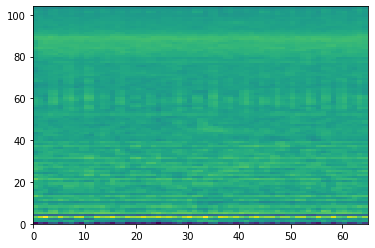

In [85]:
plt.pcolor(acoustic_features)
plt.show()

In [163]:
scale, sr = librosa.load(path_abnormal_sound[0])

In [164]:
binary_data = scale.tobytes()

In [173]:
# Preparing the input for inference

sound_input = {
    "sound": [i for i in binary_data]
}

endpoint = f"{deployment.deployment_url}/v1/models/soundmodel:predict"
headers = {"Authorization": ai_api_v2_client.rest_client.get_token(),
           'ai-resource-group': resource_group,
           "Content-Type": "application/json"}
response = requests.post(endpoint, headers=headers, json=sound_input)

print('Inference result:', response.json())
pprint(vars(response))

KeyboardInterrupt: 

# Stop deployed model

In [ ]:
delete_resp = ai_api_v2_client.deployment.modify(deployment_resp.id,
                                                 target_status=TargetStatus.STOPPED)
status = None
while status != Status.STOPPED:
    time.sleep(5)
    clear_output(wait=True)
    deployment = ai_api_v2_client.deployment.get(deployment_resp.id)
    status = deployment.status
    print('...... killing deployment ......', flush=True)
    print(f"Deployment status: {deployment.status}")